# Training

---
# 📦 Section 1: Setup & Configuration

First, let's set up our environment and create a shared configuration system that allows us to easily compare different models and training strategies.

In [ ]:
# Essential imports for deep learning and visualization
import os
import time
import random
import sys
import json
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple
from dataclasses import dataclass, field, asdict

from datetime import datetime

# Scientific computing and visualization
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import cv2
from PIL import Image

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

# HuggingFace Transformers for SegFormer
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

DATA_ROOT = "./datasets/NYUDepthv2"

COLAB = 'google.colab' in sys.modules
if COLAB:
    assert torch.cuda.is_available(), "Colab session must have a GPU enabled."
    
    from google.colab import drive
    drive.mount('/content/drive')

    DATA_ROOT = "drive/MyDrive/EGH444/datasets/NYUDepthv2"

## 🎛️ Shared Configuration System

Let's create a comprehensive configuration system that allows us to easily switch between different experimental setups. This approach ensures reproducibility and makes it easy to compare different models.

In [2]:
@dataclass
class TrainingHistory:
    """Tracks comprehensive training metrics for analysis and visualization."""
    
    # Training metrics (per epoch)
    train_loss: List[float] = field(default_factory=list)
    train_miou: List[float] = field(default_factory=list)
    train_pixacc: List[float] = field(default_factory=list)
    
    # Validation metrics (per epoch)
    val_loss: List[float] = field(default_factory=list)
    val_miou: List[float] = field(default_factory=list)
    val_pixacc: List[float] = field(default_factory=list)
    
    # Training metadata
    learning_rates: List[float] = field(default_factory=list)
    epoch_times: List[float] = field(default_factory=list)
    
    def add_epoch(self, epoch_data: Dict[str, float]) -> None:
        """Add metrics for a completed epoch."""
        self.train_loss.append(epoch_data.get("train_loss", 0.0))
        self.train_miou.append(epoch_data.get("train_miou", 0.0))
        self.train_pixacc.append(epoch_data.get("train_pixacc", 0.0))
        
        self.val_loss.append(epoch_data.get("val_loss", 0.0))
        self.val_miou.append(epoch_data.get("val_miou", 0.0))
        self.val_pixacc.append(epoch_data.get("val_pixacc", 0.0))
        
        self.learning_rates.append(epoch_data.get("learning_rate", 0.0))
        self.epoch_times.append(epoch_data.get("epoch_time", 0.0))
    
    def get_best_epoch(self, metric: str = "val_miou") -> Tuple[int, float]:
        """Get the epoch number and value of the best performance."""
        values = getattr(self, metric, [])
        if not values:
            return 0, 0.0
        best_idx = max(range(len(values)), key=lambda i: values[i])
        return best_idx + 1, values[best_idx]  # 1-indexed epoch
    
    def __len__(self) -> int:
        """Return number of completed epochs."""
        return len(self.train_loss)


@dataclass
class ModelConfig:

    # Experiment metadata (required)
    name: str
    description: str

    # Dataset configuration (required)
    data_root: str

    # Model configuration (required)
    model_name: str
    freeze_encoder: bool

    # Training hyperparameters (required)
    epochs: int
    batch_size: int
    learning_rate: float

    # Dataset configuration (with sensible defaults)
    num_classes: int = 40
    ignore_index: int = 255

    # Training hyperparameters (with sensible defaults)
    weight_decay: float = 0.01

    # Data preprocessing (with sensible defaults)
    image_size: Tuple[int, int] = (240, 320)  # (height, width)

    # System configuration (with sensible defaults)
    device: str = "auto"  # auto, cpu, cuda, mps
    num_workers: int = 2  # Number of parallel data loading processes (0=single-threaded, 2-4=good for most cases)
    seed: int = 42

    # Logging and checkpointing (with sensible defaults)
    log_every: int = 10
    save_dir: str = "checkpoints"
    
    def __post_init__(self):
        """Create save directory after initialization."""
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)
    
    @property
    def experiment_dir(self) -> Path:
        """Get experiment-specific directory."""
        return Path(self.save_dir) / self.name
    
    def save_config(self, path: Optional[str] = None) -> str:
        """Save configuration to JSON file."""
        if path is None:
            self.experiment_dir.mkdir(parents=True, exist_ok=True)
            path = self.experiment_dir / "config.json"
        
        with open(path, 'w') as f:
            json.dump(asdict(self), f, indent=2)
        return str(path)

print("✅ Configuration classes defined!")

✅ Configuration classes defined!


## ⚙️ Device Setup & Seed Management

Proper device detection and seed management are crucial for reproducible experiments.

In [4]:
def setup_device(device_preference: str = "auto") -> torch.device:
    """Set up the best available device for training."""
    if device_preference == "auto":
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("cpu") # Temporary fix for MPS issues
            # device = torch.device("mps")
        else:
            device = torch.device("cpu")
    else:
        device = torch.device(device_preference)
        
    print(f"Using device: {device}")
    
    return device

def set_random_seeds(seed: int = 42) -> None:
    """Set random seeds for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Make CuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🎲 Random seeds set to {seed} for reproducibility")


# Apply device and seed setup
device = setup_device(config.device)
set_random_seeds(config.seed)

# Save configuration for this experiment
config_path = config.save_config()
print(f"💾 Configuration saved to: {config_path}")

Using device: cpu
🎲 Random seeds set to 42 for reproducibility
💾 Configuration saved to: checkpoints/my_first_segformer/config.json


---
# 📂 Section 2: Data Loading & Transformations

NYUv2 dataset loading with SegFormer-compatible preprocessing and data augmentation.

In [5]:
def visualize_batch(batch: Dict[str, torch.Tensor], processor: SegformerImageProcessor, 
                    num_samples: int = 4) -> None:
    """Visualize samples from a batch."""
    
    # Convert SegFormer tensors back to images for visualization
    def denormalize_segformer(tensor: torch.Tensor) -> np.ndarray:
        """Denormalize SegFormer preprocessed image."""
        # SegFormer uses ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        img = tensor.permute(1, 2, 0).cpu().numpy()
        img = (img * std + mean).clip(0, 1)
        return (img * 255).astype(np.uint8)
    
    def colorize_mask(mask: np.ndarray) -> np.ndarray:
        """Create colored visualization of segmentation mask."""
        # Simple colormap for visualization
        np.random.seed(42)  # Consistent colors
        colors = np.random.randint(0, 255, (41, 3), dtype=np.uint8)  # 40 classes + ignore
        colors[40] = [0, 0, 0]  # Ignore class = black
        
        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id in range(41):
            colored[mask == class_id] = colors[class_id]
        colored[mask == 255] = [128, 128, 128]  # Ignore = gray
        
        return colored
    
    # Create visualization
    pixel_values = batch["pixel_values"]
    labels = batch["labels"] 
    ids = batch["id"]
    
    num_samples = min(num_samples, pixel_values.shape[0])
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(num_samples):
        # Denormalize image
        img = denormalize_segformer(pixel_values[i])
        mask = labels[i].cpu().numpy()
        colored_mask = colorize_mask(mask)
        
        # Plot image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Image: {ids[i]}")
        axes[0, i].axis("off")
        
        # Plot mask
        axes[1, i].imshow(colored_mask)
        axes[1, i].set_title(f"Mask: {mask.shape}")
        axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [6]:
def to_nyu40_ids(mask_np: np.ndarray) -> np.ndarray:
    """Ensure mask uses NYUv2-40 label space [0..39]. Out-of-range → 255 (ignore)."""
    out = mask_np.astype(np.int64, copy=True)
    bad = (out < 0) | (out > 39)
    out[bad] = 255
    return out


class SegFormerTransforms:
    """Enhanced data augmentation transforms for SegFormer training."""
    
    class Train:
        """Training augmentations with RGB and depth support."""
        def __init__(self, hflip_p=0.5, rotation_p=0.3, rotation_angle=15.0, 
                     color_jitter_p=0.4, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1,
                     crop_p=0.3, crop_scale=(0.8, 1.0), 
                     use_depth=False, depth_noise_p=0.3, depth_noise_std=0.02, depth_dropout_p=0.2):
            self.hflip_p = hflip_p
            self.rotation_p = rotation_p
            self.rotation_angle = rotation_angle
            self.color_jitter_p = color_jitter_p
            self.brightness = brightness
            self.contrast = contrast
            self.saturation = saturation
            self.hue = hue
            self.crop_p = crop_p
            self.crop_scale = crop_scale
            self.use_depth = use_depth
            self.depth_noise_p = depth_noise_p
            self.depth_noise_std = depth_noise_std
            self.depth_dropout_p = depth_dropout_p
        
        def _apply_crop(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None):
            """Apply random crop with zoom."""
            h, w = rgb.shape[:2]
            scale = random.uniform(*self.crop_scale)
            new_h, new_w = int(h * scale), int(w * scale)
            
            # Random crop position
            top = random.randint(0, max(0, h - new_h))
            left = random.randint(0, max(0, w - new_w))
            
            # Crop and resize back
            rgb_crop = rgb[top:top+new_h, left:left+new_w]
            label_crop = label[top:top+new_h, left:left+new_w]
            rgb = cv2.resize(rgb_crop, (w, h), interpolation=cv2.INTER_LINEAR)
            label = cv2.resize(label_crop.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int64)
            
            if depth is not None:
                depth_crop = depth[top:top+new_h, left:left+new_w]
                depth = cv2.resize(depth_crop, (w, h), interpolation=cv2.INTER_NEAREST)
                return rgb, label, depth
            
            return rgb, label
        
        def _apply_color_jitter(self, rgb: np.ndarray) -> np.ndarray:
            """Apply color jittering augmentations."""
            rgb = rgb.astype(np.float32)
            
            # Brightness
            if self.brightness > 0:
                brightness_factor = random.uniform(1 - self.brightness, 1 + self.brightness)
                rgb *= brightness_factor
            
            # Contrast
            if self.contrast > 0:
                contrast_factor = random.uniform(1 - self.contrast, 1 + self.contrast)
                mean = rgb.mean()
                rgb = (rgb - mean) * contrast_factor + mean
            
            # Saturation (convert to HSV)
            if self.saturation > 0:
                hsv = cv2.cvtColor(np.clip(rgb, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
                saturation_factor = random.uniform(1 - self.saturation, 1 + self.saturation)
                hsv[:, :, 1] *= saturation_factor
                hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
                rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)
            
            # Hue shift
            if self.hue > 0:
                hsv = cv2.cvtColor(np.clip(rgb, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
                hue_shift = random.uniform(-self.hue, self.hue) * 179  # OpenCV hue is 0-179
                hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180
                rgb = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB).astype(np.float32)
            
            return np.clip(rgb, 0, 255).astype(np.uint8)
        
        def _apply_depth_augmentation(self, depth: np.ndarray) -> np.ndarray:
            """Apply depth-specific augmentations."""
            depth = depth.copy().astype(np.float32)
            valid_mask = depth > 0
            
            # Gaussian noise
            if random.random() < self.depth_noise_p and valid_mask.any():
                noise = np.random.normal(0, self.depth_noise_std * 255, depth.shape).astype(np.float32)
                depth[valid_mask] += noise[valid_mask]
                depth = np.clip(depth, 0, 255)
            
            # Depth dropout (simulate sensor holes)
            if random.random() < self.depth_dropout_p and valid_mask.any():
                dropout_mask = np.random.random(depth.shape) < 0.05  # 5% dropout
                depth[dropout_mask & valid_mask] = 0
            
            return depth
        
        def __call__(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None) -> tuple:
            h, w = rgb.shape[:2]
            
            # Random crop with zoom
            if random.random() < self.crop_p:
                if depth is not None:
                    rgb, label, depth = self._apply_crop(rgb, label, depth)
                else:
                    rgb, label = self._apply_crop(rgb, label)
            
            # Horizontal flip
            if random.random() < self.hflip_p:
                rgb = np.ascontiguousarray(np.flip(rgb, axis=1))
                label = np.ascontiguousarray(np.flip(label, axis=1))
                if depth is not None:
                    depth = np.ascontiguousarray(np.flip(depth, axis=1))
            
            # Rotation
            if random.random() < self.rotation_p:
                angle = random.uniform(-self.rotation_angle, self.rotation_angle)
                center = (w // 2, h // 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                rgb = cv2.warpAffine(rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
                label = cv2.warpAffine(label.astype(np.uint8), M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
                label = label.astype(np.int64)
                if depth is not None:
                    depth = cv2.warpAffine(depth, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            
            # Color jitter
            if random.random() < self.color_jitter_p:
                rgb = self._apply_color_jitter(rgb)
            
            # Depth augmentation
            if depth is not None and self.use_depth:
                depth = self._apply_depth_augmentation(depth)
                return rgb, label, depth
            
            return rgb, label
    
    class Eval:
        """No augmentations for evaluation."""
        def __call__(self, rgb: np.ndarray, label: np.ndarray, depth: np.ndarray = None) -> tuple:
            if depth is not None:
                return rgb, label, depth
            return rgb, label

In [ ]:
class NYUDepthDataset(Dataset):
    """NYUv2 dataset with SegFormer preprocessing."""
    
    def __init__(self, base_dir: str, split: str, processor: SegformerImageProcessor, 
                 transform=None, image_size: Optional[Tuple[int, int]] = None):
        self.base = Path(base_dir)
        self.processor = processor
        self.transform = transform
        self.image_size = image_size

        # ensure split is valid
        assert split in ["train", "val", "test"], "split must be 'train', 'val', or 'test'"
        folder_split = "train" if split == "train" or split == "val" else "test"

        # Load split files
        with open(self.base / f"{folder_split}.txt") as f:
            stems = [Path(line.split()[0]).stem for line in f if line.strip()]
        
        # If val split, take 20% of train set
        if split == "val":
            val_size = int(0.2 * len(stems))
            stems = stems[-val_size:]
        elif split == "train":
            val_size = int(0.2 * len(stems))
            stems = stems[:-val_size]
        
        # Find valid RGB + Label pairs
        self.items = []
        for s in stems:
            rgb_path = self.base / "RGB" / f"{s}.jpg"
            if not rgb_path.exists():
                rgb_path = self.base / "RGB" / f"{s}.png"
            label_path = self.base / "Label" / f"{s}.png"
            
            if rgb_path.exists() and label_path.exists():
                self.items.append((s, rgb_path, label_path))
                
        if not self.items:
            raise RuntimeError(f"No valid samples found in {base_dir}/{folder_split}.txt")
    
    def __len__(self) -> int:
        return len(self.items)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        stem, rgb_path, label_path = self.items[idx]
        
        # Load RGB and convert BGR→RGB
        rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        
        # Load label and apply NYU40 processing
        label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE).astype(np.int64)
        label = to_nyu40_ids(label)
        
        # Apply transforms if provided (before SegFormer processing)
        if self.transform:
            rgb, label = self.transform(rgb, label)
        
        # Resize if custom size specified
        if self.image_size:
            h, w = self.image_size
            rgb = cv2.resize(rgb, (w, h), interpolation=cv2.INTER_LINEAR)
            label = cv2.resize(label.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int64)
        
        # SegFormer preprocessing
        inputs = self.processor(images=rgb, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0).contiguous()
        
        # Process labels to match processor output size
        processor_size = self.processor.size
        if isinstance(processor_size, dict):
            target_h, target_w = processor_size["height"], processor_size["width"]
        else:
            target_h = target_w = processor_size
            
        label_resized = cv2.resize(
            label.astype(np.uint8), (target_w, target_h), interpolation=cv2.INTER_NEAREST
        )
        labels = torch.from_numpy(label_resized.astype(np.int64)).contiguous()
        
        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "id": stem
        }

In [ ]:
def create_data_loaders(
    data_root: str,
    model_name: str,
    batch_size: int,
    image_size: Tuple[int, int],
    num_workers: int = 0,
    pin_memory: bool = True
) -> Tuple[DataLoader, DataLoader, DataLoader, SegformerImageProcessor]:
    """Create training, validation, and test data loaders.
    
    Args:
        data_root: Path to dataset directory
        model_name: HuggingFace model name for processor
        batch_size: Batch size for data loaders
        image_size: (height, width) for resizing
        num_workers: Number of worker processes for data loading
        pin_memory: Whether to pin memory for faster GPU transfer
    
    Returns:
        train_loader, val_loader, test_loader, processor
    """
    
    # Initialize SegFormer processor
    processor = SegformerImageProcessor.from_pretrained(model_name)
    print(f"📏 Processor size: {processor.size}")
    
    # Create transforms
    train_transform = SegFormerTransforms.Train()
    val_transform = SegFormerTransforms.Eval()
    
    # Create datasets
    train_dataset = NYUDepthDataset(
        data_root, "train", processor, 
        transform=train_transform, image_size=image_size
    )
    val_dataset = NYUDepthDataset(
        data_root, "val", processor,
        transform=val_transform, image_size=image_size
    )
    test_dataset = NYUDepthDataset(
        data_root, "test", processor,
        transform=val_transform, image_size=image_size
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    print(f"📊 Train: {len(train_dataset)} samples,  Val: {len(val_dataset)} samples,  Test: {len(test_dataset)} samples")
    print(f"📦 Train batches: {len(train_loader)},  Val batches: {len(val_loader)},  Test batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader, processor

In [9]:
def show_augmentations(dataset, sample_idx: int = 0, num_augmentations: int = 6, use_depth: bool = False):
    """Show multiple augmentations of a single sample without SegFormer preprocessing."""
    
    # Get raw sample without transforms
    stem, rgb_path, label_path = dataset.items[sample_idx]
    
    # Load RGB and label
    rgb = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    label = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE).astype(np.int64)
    label = to_nyu40_ids(label)
    
    # Load depth if requested
    depth = None
    if use_depth:
        depth_path = dataset.base / "Depth" / f"{stem}.png"
        if depth_path.exists():
            depth = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        else:
            print(f"⚠️ Depth file not found: {depth_path}")
            use_depth = False
    
    # Create transform with enhanced settings for visualization
    transform = SegFormerTransforms.Train(
        hflip_p=0.8, rotation_p=0.8, rotation_angle=20,
        color_jitter_p=0.8, brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15,
        crop_p=0.6, crop_scale=(0.7, 1.0),
        use_depth=use_depth, depth_noise_p=0.8, depth_noise_std=0.03, depth_dropout_p=0.5
    )
    
    def colorize_mask(mask: np.ndarray) -> np.ndarray:
        """Create colored visualization of segmentation mask."""
        np.random.seed(42)  # Consistent colors
        colors = np.random.randint(0, 255, (41, 3), dtype=np.uint8)
        colors[40] = [0, 0, 0]  # Ignore class = black
        
        colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for class_id in range(41):
            colored[mask == class_id] = colors[class_id]
        colored[mask == 255] = [128, 128, 128]  # Ignore = gray
        return colored
    
    # Create visualization
    num_cols = num_augmentations + 1  # +1 for original
    num_rows = 3 if use_depth else 2  # RGB, Mask, (Depth)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Show original
    axes[0, 0].imshow(rgb)
    axes[0, 0].set_title("Original RGB")
    axes[0, 0].axis("off")
    
    axes[1, 0].imshow(colorize_mask(label))
    axes[1, 0].set_title("Original Mask")
    axes[1, 0].axis("off")
    
    if use_depth and depth is not None:
        axes[2, 0].imshow(depth, cmap='plasma')
        axes[2, 0].set_title("Original Depth")
        axes[2, 0].axis("off")
    
    # Show augmentations
    for i in range(num_augmentations):
        # Apply transform
        if use_depth and depth is not None:
            rgb_aug, label_aug, depth_aug = transform(rgb.copy(), label.copy(), depth.copy())
        else:
            rgb_aug, label_aug = transform(rgb.copy(), label.copy())
        
        # Display RGB
        axes[0, i+1].imshow(rgb_aug)
        axes[0, i+1].set_title(f"Aug {i+1} RGB")
        axes[0, i+1].axis("off")
        
        # Display mask
        axes[1, i+1].imshow(colorize_mask(label_aug))
        axes[1, i+1].set_title(f"Aug {i+1} Mask")
        axes[1, i+1].axis("off")
        
        # Display depth if available
        if use_depth and depth is not None:
            axes[2, i+1].imshow(depth_aug, cmap='plasma')
            axes[2, i+1].set_title(f"Aug {i+1} Depth")
            axes[2, i+1].axis("off")
    
    plt.tight_layout()
    plt.suptitle(f"Augmentations for sample: {stem}", y=1.02, fontsize=16)
    plt.show()

In [ ]:
segformer_config = ModelConfig(
    name="segformer",
    description="SegFormer-B0 with frozen encoder",
    data_root=DATA_ROOT,
    model_name="nvidia/segformer-b0-finetuned-ade-512-512",
    freeze_encoder=True,
    epochs=5,
    batch_size=8,
    learning_rate=6e-5,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues in Jupyter
)

In [ ]:
# Create data loaders with individual parameters
train_loader, val_loader, test_loader, processor = create_data_loaders(
    data_root=segformer_config.data_root,
    model_name=segformer_config.model_name,
    batch_size=segformer_config.batch_size,
    image_size=segformer_config.image_size,
    num_workers=segformer_config.num_workers,
    pin_memory=True  # Can override config if needed
)

# Test data loading and visualization
print("\\n🧪 Testing data loading...")
sample_batch = next(iter(train_loader))
print(f"✅ Batch loaded successfully!")
print(f"📏 pixel_values shape: {sample_batch['pixel_values'].shape}")
print(f"📏 labels shape: {sample_batch['labels'].shape}")
print(f"🏷️ Sample IDs: {sample_batch['id'][:3]}")

# Visualize samples (uncomment to see)
visualize_batch(sample_batch, processor, num_samples=2)

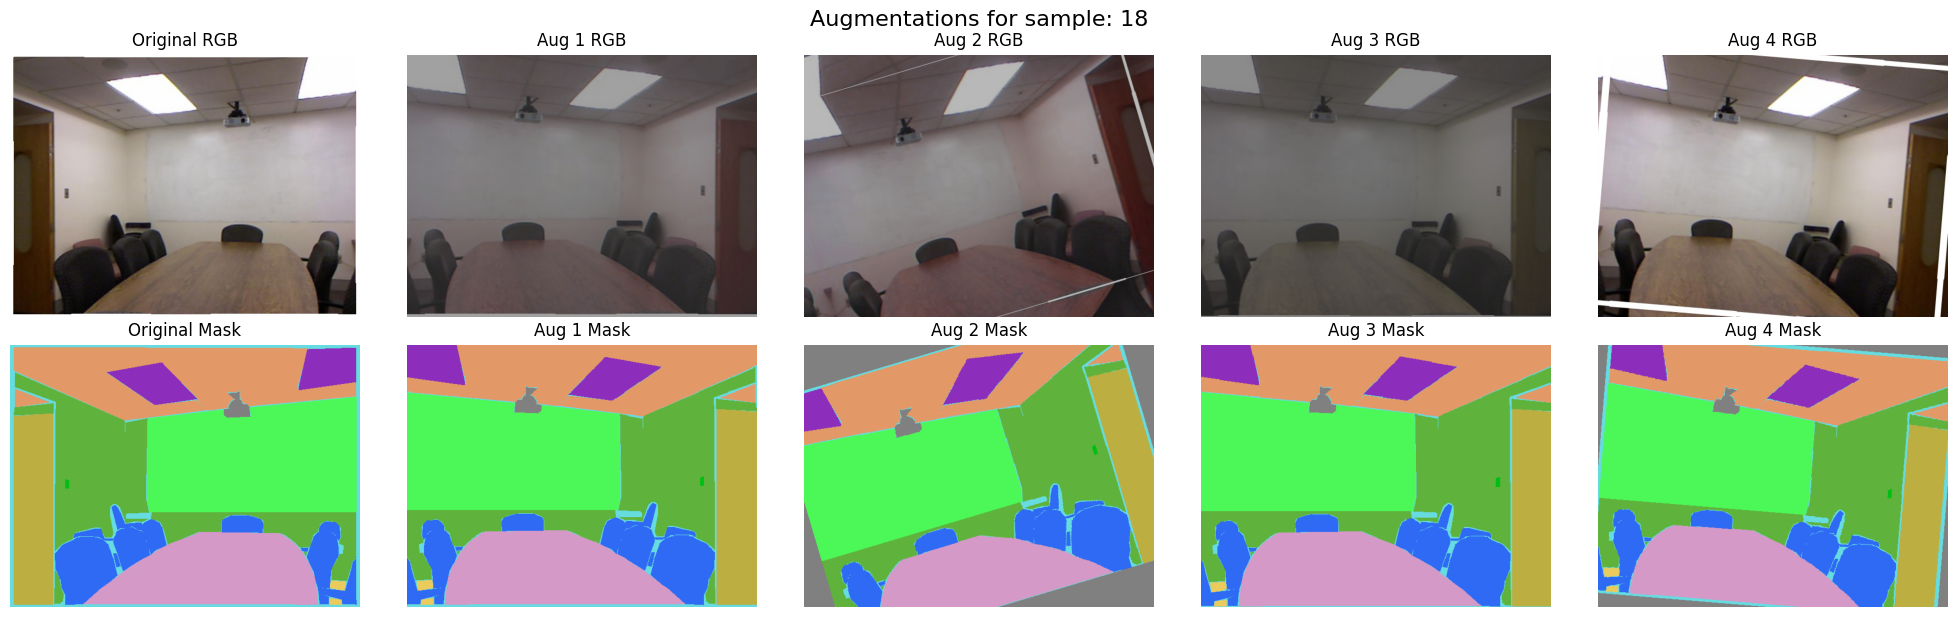

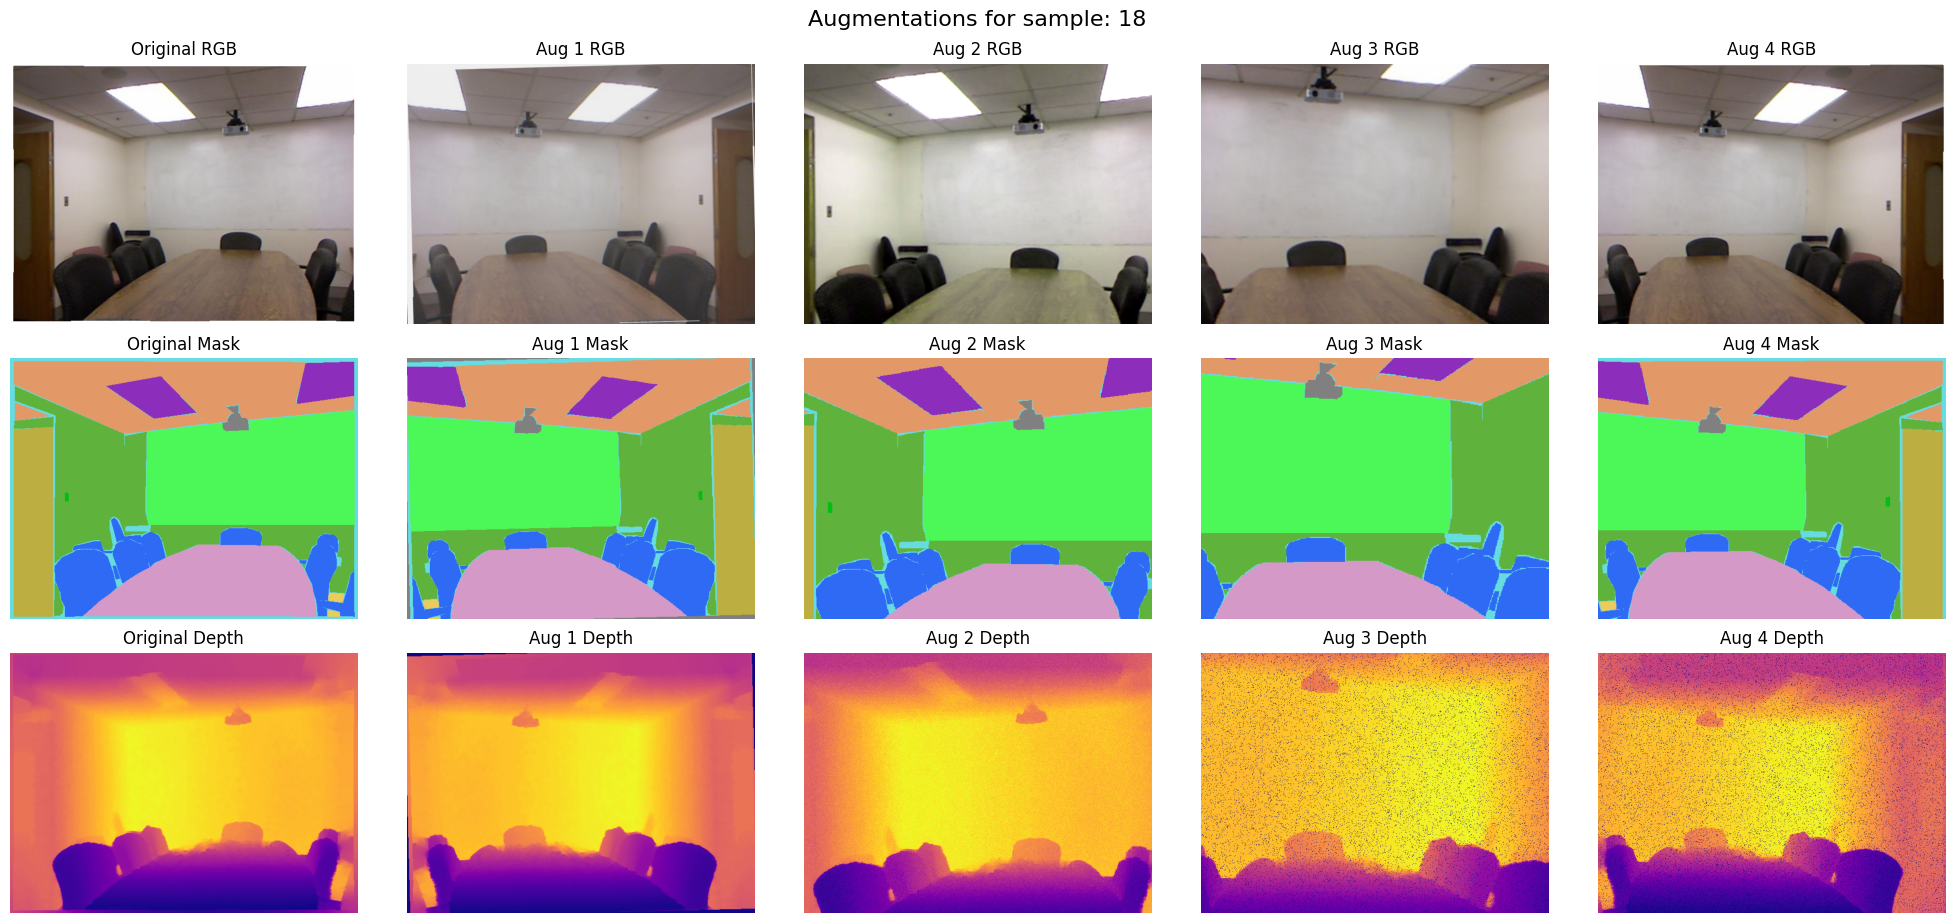

In [11]:
show_augmentations(train_loader.dataset, sample_idx=10, num_augmentations=4, use_depth=False)
show_augmentations(train_loader.dataset, sample_idx=10, num_augmentations=4, use_depth=True)

---
# 📊 Section 3: Training Utils

---
# 📊 Section 3: Training Utils

Training utilities with cosine annealing scheduler and comprehensive checkpoint management.

In [ ]:
print("✅ Checkpoint and training utilities are defined in the cells below")

In [ ]:
print("✅ Training utilities with scheduler support are in the final cells")

In [ ]:
# Checkpoint and Resume Functions
import glob

def save_checkpoint(model, optimizer, scaler, scheduler, epoch, history, best_miou, config, checkpoint_path):
    """Save training checkpoint with scheduler state."""
    # Ensure directory exists
    checkpoint_path = Path(checkpoint_path)
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "history": history.__dict__,  # Convert to dict for JSON serialization
        "best_miou": best_miou,
        "config": config.__dict__,
        "timestamp": datetime.now().isoformat()
    }
    
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

def save_history_json(history, config):
    """Save training history as JSON."""
    # Ensure experiment directory exists
    config.experiment_dir.mkdir(parents=True, exist_ok=True)
    
    history_data = {
        "epochs_completed": len(history),
        "best_miou": max(history.val_miou) if history.val_miou else 0.0,
        "best_epoch": history.get_best_epoch("val_miou")[0],
        "metrics": {
            "train_loss": history.train_loss,
            "train_miou": history.train_miou,
            "train_pixacc": history.train_pixacc,
            "val_loss": history.val_loss,
            "val_miou": history.val_miou,
            "val_pixacc": history.val_pixacc,
            "learning_rates": history.learning_rates,
            "epoch_times": history.epoch_times
        },
        "timestamp": datetime.now().isoformat()
    }
    
    history_path = config.experiment_dir / "training_history.json"
    with open(history_path, 'w') as f:
        json.dump(history_data, f, indent=2)

def find_latest_checkpoint(experiment_dir):
    """Find the latest checkpoint in experiment directory."""
    experiment_dir = Path(experiment_dir)
    
    # Return None if experiment directory doesn't exist
    if not experiment_dir.exists():
        return None
        
    checkpoint_pattern = str(experiment_dir / "checkpoint_epoch_*.pt")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        return None
    
    # Extract epoch numbers and find the latest
    epoch_numbers = []
    for filepath in checkpoint_files:
        filename = Path(filepath).name
        # Extract epoch number from checkpoint_epoch_X.pt
        epoch_str = filename.replace("checkpoint_epoch_", "").replace(".pt", "")
        try:
            epoch_numbers.append((int(epoch_str), filepath))
        except ValueError:
            continue
    
    if epoch_numbers:
        latest_epoch, latest_path = max(epoch_numbers, key=lambda x: x[0])
        return latest_path
    
    return None

def load_checkpoint(checkpoint_path, model, optimizer, scaler, scheduler):
    """Load checkpoint and restore training state including scheduler."""
    print(f"📂 Loading checkpoint: {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Load model state
    model.load_state_dict(checkpoint["model_state_dict"])
    
    # Load optimizer state
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    # Load scaler state
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    
    # Load scheduler state (with backward compatibility)
    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        print("   • Scheduler state loaded")
    else:
        print("   • No scheduler state found (older checkpoint)")
    
    # Reconstruct history object
    history = TrainingHistory()
    history_dict = checkpoint["history"]
    for key, value in history_dict.items():
        setattr(history, key, value)
    
    epoch = checkpoint["epoch"]
    best_miou = checkpoint["best_miou"]
    
    print(f"✅ Checkpoint loaded successfully!")
    print(f"   • Epoch: {epoch}")
    print(f"   • Best mIoU: {best_miou:.4f}")
    print(f"   • History length: {len(history)}")
    print(f"   • Current LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    return epoch, history, best_miou

print("✅ Checkpoint functions defined")

In [ ]:
@torch.no_grad()
def evaluate_segformer(
    model: SegformerForSemanticSegmentation,
    loader: DataLoader,
    num_classes: int,
    ignore_index: int = 255,
    device=None,
):
    """Evaluate SegFormer model on dataset."""
    model.eval()
    device = device or next(model.parameters()).device

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    total, correct = 0, 0

    for batch in loader:
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        targets = batch["labels"].to(device, non_blocking=True)

        # SegFormer forward pass
        with autocast(device_type=device.type, enabled=(device.type == "cuda")):
            outputs = model(pixel_values)
            logits = outputs.logits  # SegFormer returns logits in .logits
        
        # Upsample logits to target size if needed
        if logits.shape[-2:] != targets.shape[-2:]:
            logits = torch.nn.functional.interpolate(
                logits, size=targets.shape[-2:], mode="bilinear", align_corners=False
            )

        pred = logits.argmax(1)  # [B,H,W]

        valid = targets != ignore_index
        total += valid.sum().item()
        correct += (pred[valid] == targets[valid]).sum().item()

        p = pred[valid].view(-1).cpu().numpy()
        t = targets[valid].view(-1).cpu().numpy()
        for i in range(p.shape[0]):
            if 0 <= t[i] < num_classes and 0 <= p[i] < num_classes:
                cm[t[i], p[i]] += 1

    inter = np.diag(cm).astype(np.float64)
    gt = cm.sum(1).astype(np.float64)
    pr = cm.sum(0).astype(np.float64)
    union = gt + pr - inter
    iou = inter / np.maximum(union, 1)
    miou = float(np.nanmean(iou)) if iou.size > 0 else 0.0
    pixacc = float(correct / max(total, 1))

    return {"mIoU": miou, "PixelAcc": pixacc, "IoU_per_class": iou}


def train_segformer(
    model: SegformerForSemanticSegmentation,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: ModelConfig,
    device: torch.device,
    resume_path: Optional[str] = None
) -> TrainingHistory:
    """Train SegFormer model with cosine annealing scheduler and comprehensive tracking.
    
    Args:
        resume_path: Optional specific checkpoint path to resume from. 
                    If None, automatically finds latest checkpoint.
    """
    
    # Setup training components
    criterion = nn.CrossEntropyLoss(ignore_index=config.ignore_index)
    optimizer = optim.AdamW(
        model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay
    )
    scaler = GradScaler(enabled=(device.type == "cuda"))
    
    # Setup cosine annealing scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs, eta_min=0)
    
    print(f"📈 Using Cosine Annealing LR scheduler:")
    print(f"   • Initial LR: {config.learning_rate:.2e}")
    print(f"   • Final LR (eta_min): 0")
    print(f"   • T_max (epochs): {config.epochs}")

    # Check for existing checkpoints and auto-resume
    start_epoch = 1
    history = TrainingHistory()
    best_miou = -1.0
    
    # Use specific resume path or find latest automatically
    checkpoint_to_load = resume_path or find_latest_checkpoint(config.experiment_dir)
    
    if checkpoint_to_load:
        print(f"🔍 Found checkpoint: {checkpoint_to_load}")
        start_epoch, history, best_miou = load_checkpoint(checkpoint_to_load, model, optimizer, scaler, scheduler)
        start_epoch += 1  # Start from next epoch
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        print("📂 No existing checkpoints found. Starting fresh training...")

    print(f"🚀 Starting training for {config.epochs} epochs...")
    print(f"📊 Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

    for epoch in range(start_epoch, config.epochs + 1):
        model.train()
        running_loss = 0.0
        epoch_start = time.time()

        print(f"\\n📈 Epoch {epoch}/{config.epochs}")

        for it, batch in enumerate(train_loader, start=1):
            pixel_values = batch["pixel_values"].to(device, non_blocking=True)
            targets = batch["labels"].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            # SegFormer forward pass with mixed precision
            with autocast(device_type=device.type, enabled=(device.type == "cuda")):
                outputs = model(pixel_values)
                logits = outputs.logits  # SegFormer returns logits in .logits

                # Upsample logits to target size if needed
                if logits.shape[-2:] != targets.shape[-2:]:
                    logits = torch.nn.functional.interpolate(
                        logits, size=targets.shape[-2:], mode="bilinear", align_corners=False
                    )

                loss = criterion(logits, targets)

            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # Log periodically
            if it % config.log_every == 0:
                avg_loss = running_loss / it
                current_lr = optimizer.param_groups[0]['lr']
                print(f"   Batch {it:05d}/{len(train_loader)} | Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")

        # Step the scheduler after each epoch
        scheduler.step()

        # Validation
        print("🔍 Running validation...")
        val_metrics = evaluate_segformer(
            model, val_loader, config.num_classes, config.ignore_index, device
        )

        # Calculate epoch metrics
        epoch_time = time.time() - epoch_start
        avg_train_loss = running_loss / len(train_loader)
        current_lr = optimizer.param_groups[0]['lr']

        # Add to history
        history.add_epoch({
            "train_loss": avg_train_loss,
            "train_miou": 0.0,  # Could add training metrics if desired
            "train_pixacc": 0.0,
            "val_loss": 0.0,    # Could add validation loss if desired
            "val_miou": val_metrics["mIoU"],
            "val_pixacc": val_metrics["PixelAcc"],
            "learning_rate": current_lr,
            "epoch_time": epoch_time
        })

        # Save training history as JSON after each epoch
        save_history_json(history, config)

        # Print epoch summary
        print(f"\\n📊 Epoch {epoch} Results:")
        print(f"   • Train Loss: {avg_train_loss:.4f}")
        print(f"   • Val mIoU: {val_metrics['mIoU']:.4f}")
        print(f"   • Val PixelAcc: {val_metrics['PixelAcc']:.4f}")
        print(f"   • Epoch Time: {epoch_time:.1f}s")
        print(f"   • Learning Rate: {current_lr:.2e}")

        # Save best model
        if val_metrics["mIoU"] > best_miou:
            best_miou = val_metrics["mIoU"]

            # Save best model checkpoint
            config.experiment_dir.mkdir(parents=True, exist_ok=True)
            best_checkpoint_path = config.experiment_dir / "best_model.pth"

            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "config": config,
                "metrics": val_metrics,
                "history": history,
                "best_miou": best_miou
            }

            torch.save(checkpoint, best_checkpoint_path)
            print(f"✅ Saved best model to {best_checkpoint_path} (mIoU: {best_miou:.4f})")

        # Save checkpoint every 5 epochs
        if epoch % 5 == 0:
            checkpoint_path = config.experiment_dir / f"checkpoint_epoch_{epoch}.pt"
            save_checkpoint(model, optimizer, scaler, scheduler, epoch, history, best_miou, config, checkpoint_path)

        print("-" * 80)

    print(f"\\n🎉 Training Complete!")
    print(f"   • Best Validation mIoU: {best_miou:.4f}")
    print(f"   • Total Training Time: {sum(history.epoch_times):.1f}s")
    print(f"   • Final Learning Rate: {current_lr:.2e}")

    return history

In [ ]:
segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    segformer_config.model_name,
    num_labels=segformer_config.num_classes,
    ignore_mismatched_sizes=True
)

# Start training (automatically resumes from latest checkpoint if available)
history = train_segformer(segformer_model, train_loader, val_loader, segformer_config, device)

print("\\n🎯 Training Results Summary:")
print(f"   • Epochs completed: {len(history)}")
if len(history) > 0:
    best_epoch, best_miou = history.get_best_epoch("val_miou")
    print(f"   • Best mIoU: {best_miou:.4f} (epoch {best_epoch})")
    print(f"   • Final validation mIoU: {history.val_miou[-1]:.4f}")
    print(f"   • Total training time: {sum(history.epoch_times):.1f}s")
else:
    print("   • No training completed")

📂 No existing checkpoints found. Starting fresh training...
🚀 Starting training for 5 epochs...
📊 Training batches: 80, Validation batches: 20
\n📈 Epoch 1/5
   Batch 00010/80 | Loss: 3.6621 | LR: 6.00e-05
   Batch 00020/80 | Loss: 3.6276 | LR: 6.00e-05
